In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.stats import poisson, uniform, expon, pareto
from scipy.optimize import minimize, fsolve
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

In [2]:
def getEquilBids(cs, a, guess=None):
    n = len(cs)
    bs = [sp.Symbol('b{}'.format(i)) for i in range(n)]
    
    denom = sum([bi**(-a) for bi in bs])
    xs    = [bi**(-a)/denom for bi in bs]
    us    = [(bs[i] - cs[i])*xs[i] for i in range(n)]
    diffs = [sp.diff(us[i], bs[i]) for i in range(n)]
    funcs = [sp.lambdify(bs, diffs[i]) for i in range(n)]
    
    def eqs(bs):
        return [f(*bs) for f in funcs]
    
    initial_guess = cs
    if guess != None:
        initial_guess = guess
    
    return fsolve(eqs, initial_guess)

def getAllos(bids, a):
    denom = sum([b**(-a) for b in bids])
    return np.array(bids**(-a)) / denom

In [12]:
alpha = 3.
c1s   = np.arange(1, 10.01, 0.1)
c1s

array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,
        2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,
        3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,
        4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,
        5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,
        6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,
        7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,
        8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,
        9.8,  9.9, 10. ])

In [15]:
guesses = c1s

xTildes  = []
welfares = [] 
for i, c1 in enumerate(c1s):
    costs   = [1, c1]
    bids    = getEquilBids(costs, a=alpha, guess=[guesses[i],guesses[i]])
    xTilde  = getAllos(bids, a=alpha)
    xTildes.append(xTilde)
    welfares.append(np.dot(costs, xTilde))
xTildes = np.asarray(xTildes)
welfares = np.asarray(welfares)
xTildes.shape, welfares.shape

((91, 2), (91,))

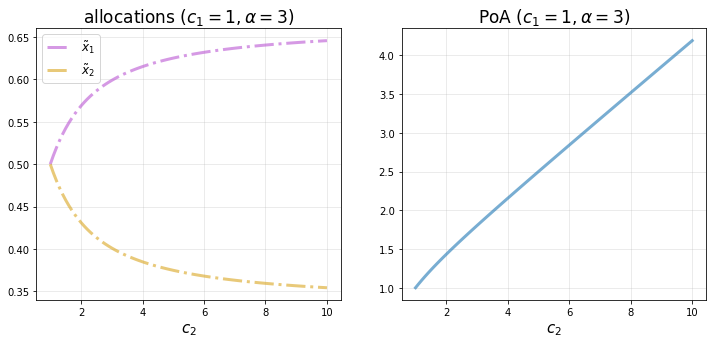

In [18]:
f, axarr = plt.subplots(ncols=2, figsize=(12,5))

axarr[0].plot(c1s, xTildes[:,0], linewidth=3, alpha=0.6, label=r'$\tilde{x}_1$', color='mediumorchid',
              linestyle='-.')
axarr[0].plot(c1s, xTildes[:,1], linewidth=3, alpha=0.6, label=r'$\tilde{x}_2$', color='goldenrod',
              linestyle='-.')

axarr[1].plot(c1s, welfares, linewidth=3, alpha=0.6)

for ax in axarr:
    ax.grid(alpha=0.3)
    ax.set_xlabel(r'$c_2$', size=15)
axarr[0].legend(prop={'size': 12})
axarr[0].set_title(r'allocations $(c_1=1, \alpha=3)$', size=17)
axarr[1].set_title(r'PoA $(c_1=1, \alpha=3)$', size=17)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [25]:
costs = [1, 5]

In [26]:
bids = getEquilBids(costs, a=alpha, guess=costs)
bids

array([ 9.03191683, 10.71104368])

In [27]:
allos = getAllos(bids, a=alpha)
allos

array([0.62516557, 0.37483443])

In [31]:
sc = np.dot(costs, allos)
sc

2.4993377083378556

# sympy for diff for PoA

In [206]:
b0 = sp.Symbol('b0', positive=True)
R = sp.Symbol('R', positive=True)
alpha = sp.Symbol('alpha', positive=True)
N = sp.Symbol('N', positive=True)

In [207]:
u0 = ( (b0 - 1)*b0**(-alpha) ) / ( b0**(-alpha) + N*R**(-alpha) )
u0

(b0 - 1)/(b0**alpha*(N/R**alpha + b0**(-alpha)))

In [208]:
du0_db0 = sp.diff(u0, b0)
du0_db0

-alpha*(b0 - 1)/(b0*b0**alpha*(N/R**alpha + b0**(-alpha))) + alpha*(b0 - 1)/(b0*b0**(2*alpha)*(N/R**alpha + b0**(-alpha))**2) + 1/(b0**alpha*(N/R**alpha + b0**(-alpha)))

In [209]:
foc = sp.Eq(sp.simplify(du0_db0),0)
foc

Eq(R**alpha*(R**alpha*alpha*(b0 - 1) - alpha*(b0 - 1)*(N*b0**alpha + R**alpha) + b0*(N*b0**alpha + R**alpha))/(b0*(N*b0**alpha + R**alpha)**2), 0)

In [179]:
sp.solve(foc, b0)

NotImplementedError: multiple generators [b0, b0**alpha]
No algorithms are implemented to solve equation R**alpha*alpha*(b0 - 1) - alpha*(b0 - 1)*(N*b0**alpha + R**alpha) + b0*(N*b0**alpha + R**alpha)

In [210]:
du0_db0

-alpha*(b0 - 1)/(b0*b0**alpha*(N/R**alpha + b0**(-alpha))) + alpha*(b0 - 1)/(b0*b0**(2*alpha)*(N/R**alpha + b0**(-alpha))**2) + 1/(b0**alpha*(N/R**alpha + b0**(-alpha)))

In [211]:
eq_numeric = du0_db0.evalf(subs={alpha:4., N:1., R:2.})
eq_numeric

4.0*(b0 - 1.0)/(b0**9.0*(b0**(-4.0) + 0.0625)**2) - 4.0*(b0 - 1.0)/(b0**5.0*(b0**(-4.0) + 0.0625)) + 1/(b0**4.0*(b0**(-4.0) + 0.0625))

In [212]:
du0_db0

-alpha*(b0 - 1)/(b0*b0**alpha*(N/R**alpha + b0**(-alpha))) + alpha*(b0 - 1)/(b0*b0**(2*alpha)*(N/R**alpha + b0**(-alpha))**2) + 1/(b0**alpha*(N/R**alpha + b0**(-alpha)))

In [213]:
b0_sol = sp.nsolve(sp.Eq(eq_numeric, 0), b0, guess)
b0_sol

2.00000000000000

# numerical for diff for PoA

In [93]:
from scipy.optimize import brentq, newton

def u0_derivative(b0, N_, R_, alpha_):
    guess = 1
    eq_numeric = du0_db0.evalf(subs={N:1., R:2., alpha_})
    b0_sol = sp.nsolve(sp.Eq(eq_numeric, 0), b0, guess)
    return derivative_value

In [214]:
def getAllo(b0, N_, R_, alpha_):
    return b0**(-alpha_) / (b0**(-alpha_) + N_*R_**(-alpha_))

In [266]:
N_ = 1
R_ = 8
alpha_ = 4
guess = 4
eq_numeric = du0_db0.evalf(subs={N:N_, R:R_, alpha:alpha_})
b0_star = sp.nsolve(sp.Eq(eq_numeric, 0), b0, guess)
b0_star

6.44154386309126

In [231]:
eq_numeric

1/(b0**6*(0.015625 + b0**(-6))) - 6.0*(b0 - 1.0)/(b0**7*(0.015625 + b0**(-6))) + 6.0*(b0 - 1.0)/(b0**13*(0.015625 + b0**(-6))**2)

In [216]:
x0 = getAllo(b0_star, N_, R_, alpha_)
xm1 = 1-x0
x0, xm1

(0.500000000000000, 0.500000000000000)

In [217]:
PoA = x0 + N_*R_*xm1
PoA

1.50000000000000

In [241]:
def getPoA(N_, R_, alpha_, guess):
    eq_numeric = du0_db0.evalf(subs={N:N_, R:R_, alpha:alpha_})
    b0_star = sp.nsolve(sp.Eq(eq_numeric, 0), b0, guess)
    x0 = getAllo(b0_star, N_, R_, alpha_)
    xm1 = 1-x0
    return x0 + N_*R_*xm1

In [249]:
getPoA(10., 2., 3., guess=1.5)

17.1162088903224

In [268]:
rs = [2, 4, 8]
ns = np.arange(1, 20)
alphas = [3, 4, 5]
guesses = [1.5, 2, 4]

poas = []
for i, R_ in enumerate(rs):
    temp = []
    for N_ in ns:
        temp2 = []
        for alpha_ in alphas:
            # print(N_, R_, alpha_)
            temp2.append(getPoA(N_, R_, alpha_, guesses[i]))
        temp.append(temp2)
    poas.append(temp)
poas = np.array(poas)
poas.shape

(3, 19, 3)

In [286]:
def getHonestAllos(N_, R_, alpha_):
    costs = [R_]*N_
    costs.append(1.)
    costs = np.array(costs)
    return costs, costs**(-alpha_) / sum(costs**(-alpha_))

In [285]:
getHonestAllos(5,5,3)

array([0.00769231, 0.00769231, 0.00769231, 0.00769231, 0.00769231,
       0.96153846])

In [288]:
welfares = [] 
for i, R_ in enumerate(rs):
    temp = []
    for N_ in ns:
        temp2 = []
        for alpha_ in alphas:
            costs, allos = getHonestAllos(N_, R_, alpha_)
            social_cost = np.dot(costs, allos)
            temp2.append(social_cost)
        temp.append(temp2)
    welfares.append(temp)
welfares = np.array(welfares)
welfares.shape

(3, 19, 3)

In [293]:
costs, allos = getHonestAllos(5, 5, 3)
costs, allos, np.dot(costs, allos)

(array([5., 5., 5., 5., 5., 1.]),
 array([0.00769231, 0.00769231, 0.00769231, 0.00769231, 0.00769231,
        0.96153846]),
 1.1538461538461537)

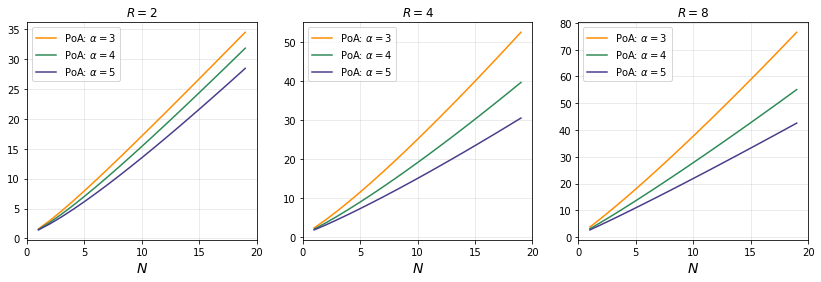

In [295]:
f, axarr = plt.subplots(ncols=3, figsize=(14,4))

colors = ['darkorange', 'seagreen', 'darkslateblue']
for i in range(3):
    for j in range(3):
        axarr[i].plot(ns, poas[i,:,j], label=r'PoA: $\alpha=${}'.format(alphas[j]), color=colors[j])
#         axarr[i].plot(ns, welfares[i,:,j], label=r'Welfare loss: $\alpha=${}'.format(alphas[j]), 
#                       color=colors[j], linestyle='--')
    
for i, ax in enumerate(axarr):
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_xticks(np.arange(0,21,5))
    ax.set_xlabel(r'$N$', size=14)
    ax.set_title(r'$R={}$'.format(rs[i], size=14))

plt.savefig('out.png', dpi=400, bbox_inches='tight', facecolor='white')